In [1]:
import wandb
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, classification_report

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
project_name = 'SMAI-A3'
entity = 'vedanivas'

# 4 CNN and AutoEncoders

In [3]:
group_name = 'CNN'

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, random_split, TensorDataset
from torchvision import transforms, datasets

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

data_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
data_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

single_data_train = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
single_data_test = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

data = ConcatDataset([data_train, data_test])

## 4.1 Data Visualization and Preprocessing 

### 4.1.1

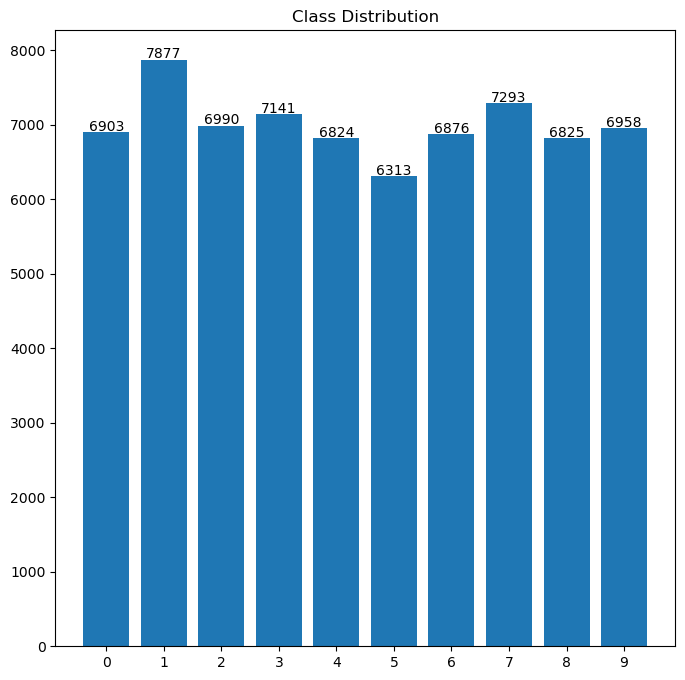

In [7]:
classes, frq = np.unique([img[1] for i, img in enumerate(data)], return_counts=True)

plt.figure(figsize=(8,8))
graph = plt.bar(classes, frq)
plt.xticks(classes)
plt.title("Class Distribution")

i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    plt.text(x+(width/2),
             y + frq[i] + 20,
             str(frq[i]),
             rotation=0,
             ha='center', rotation_mode='anchor')
    i += 1

plt.show()

### 4.1.2

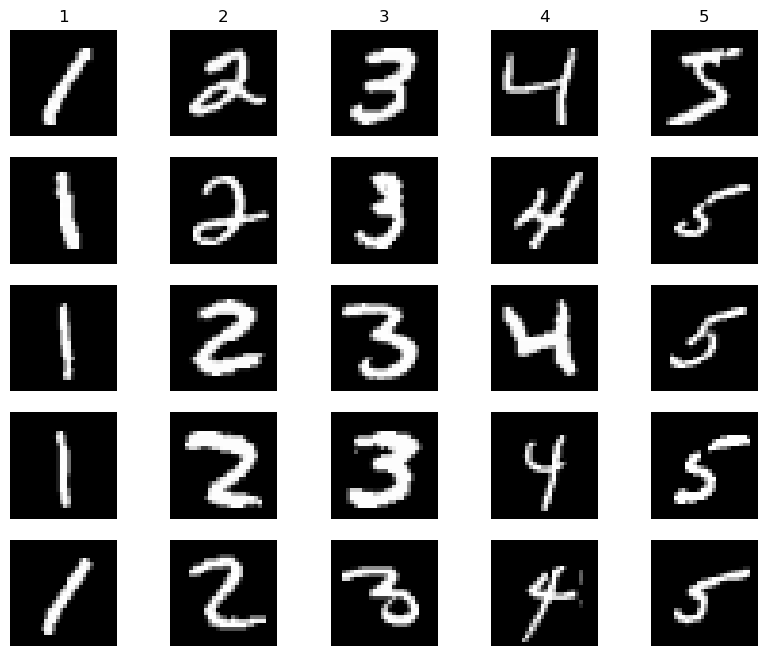

In [8]:
digits = [1, 2, 3, 4, 5]

idxs = []
for d in digits:
    idx = []
    for i, (_, lbl) in enumerate(data_train):
        if len(idx) == 5:
            break
        if lbl == d:
            idx.append(i)
    idxs.append(idx)

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    img, label = data_train[idxs[i % 5][i // 5]]
    figure.add_subplot(rows, cols, i + 1)
    if (i < cols): 
        plt.title(digits[i])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### 4.1.3

**Yes, there is class imbalance as seen from the bar graph above**

### 4.1.4

In [9]:
ratio = (0.7, 0.15, 0.15)
batch_size = 64

total_size = len(data)
train_size = int(ratio[0] * total_size)
val_size = int(ratio[1] * total_size)
test_size = total_size - train_size - val_size

gen=torch.Generator().manual_seed(0)
data_train, data_val, data_test = random_split(data, [train_size, val_size, test_size], generator=gen)

inputs = [data_train, data_val, data_test]
single_inputs = inputs.copy()
# Device?
# num_workers?

### 4.1.5

In [10]:
def visualise_feature_maps(model, dataloader):
    model.eval()
    images, labels = next(iter(dataloader))
    image = images[0].unsqueeze(0)
    lbl = labels[0]
    conv1 = model.layer1[0]
    activated1 = model.layer1[1]
    pooled1 = model.layer1[2]
    
    conv2 = model.layer2[0]
    activated2 = model.layer2[1]
    pooled2 = model.layer2[2]
    
    with torch.no_grad():
        feature_map1 = pooled1(activated1(conv1(image)))
        feature_map2 = pooled2(activated2(conv2(feature_map1)))
    
    figure = plt.figure(figsize=(10, 8))
    figure.suptitle('Digit: ' + str(lbl.item()))
    figure.tight_layout(pad=2.0)
    cols, rows = 10, 2
    for i in range(cols * rows):
        img = feature_map1[0, i % cols] if i < cols else feature_map2[0, i]
        figure.add_subplot(rows, cols, i + 1)
        plt.axis("off")
        ttl = 'Layer 1' if i < cols else 'Layer 2' 
        plt.title(ttl)
        plt.imshow(img.squeeze(0), cmap="gray")

## 4.2 Model Building

In [422]:
class BaselineCNN(nn.Module):
    def __init__(self, size1=5, size2=2, size3=5, size4=2, stride1=1, stride2=2, stride3=1, stride4=2, dropout_rate=0.5, alpha=1e-2, out_shape=7, epochs=0, batch_size=0):
        super(BaselineCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=size1, stride=stride1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=size2, stride=stride2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=size3, stride=stride3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=size4, stride=stride4))
        self.drop_out = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(out_shape * out_shape * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.softmax = nn.Softmax(1)
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = optim.Adam(self.parameters(), lr=alpha)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
#         out = self.softmax(out)
        return out

In [435]:
_, y_true, y_pred = train_test(data=inputs, test=True)

Epoch [1/1] loss:  0.54 - accuracy:  84.56% - val_loss:  0.15 - val_accuracy:  95.51%

test_loss:  0.15 - test_accuracy:  95.68%


In [434]:
def train_test(test=False, visualise=False, params=None, data=None):    
    # For logging during tuning (sweeps)
    final_accuracy = 0.0
    
    batch_size = 64
    epochs = 1
    if params is None:
        model = BaselineCNN()
    else:
        # Taking padding as 2 always
        out_shape = int((data[0][0][0].size(1) - params['size1'] + 4) / params['stride1']) + 1
        out_shape = int((out_shape - params['size2']) / params['stride2']) + 1 
        out_shape = int((out_shape - params['size3'] + 4) / params['stride3']) + 1 
        out_shape = int((out_shape - params['size4']) / params['stride4']) + 1
        params['out_shape'] = out_shape
        model = BaselineCNN(**params)
        batch_size = params['batch_size']
        epochs = params['epochs']
    criterion = model.criterion
    optimizer = model.optimiser
    
    loaders = {
        'train': DataLoader(data[0], batch_size=batch_size, shuffle=True),
        'val': DataLoader(data[1], batch_size=batch_size),
        'test': DataLoader(data[2], batch_size=batch_size),
    }
    
    # This also copied from another cell which was above test_model function and made minor changes
    for ep in range(epochs):
        model.train()

        ep_loss = 0.0
        ep_corr = 0
        ep_total = 0
        for _, (inputs, labels) in enumerate(loaders['train']):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            ep_total += labels.size(0) 
            ep_corr += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ep_loss += loss.item()

        # Function test_model copied here
        model.eval()

        ep_val_loss = 0.0  
        ep_val_corr = 0  
        ep_val_total = 0  

        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                _, predicted = torch.max(outputs.data, 1)

                ep_val_total += labels.size(0) 
                ep_val_corr += (predicted == labels).sum().item() 

                loss = criterion(outputs, labels)
                ep_val_loss += loss.item()

        loss, val_loss = ep_loss / len(loaders['train']), ep_val_loss / len(loaders['val'])
        accuracy, val_accuracy = ep_corr / ep_total, ep_val_corr / ep_val_total
        data_log = {
            'ep_loss': loss,
            'ep_accuracy': accuracy,
            'ep_val_loss': val_loss,
            'ep_val_accuracy': val_accuracy,
        }
#         wandb.log(data_log)
        print(f"Epoch [{ep + 1}/{epochs}] loss: {loss: .2f} - accuracy: {accuracy: .2%} - val_loss: {val_loss: .2f} - val_accuracy: {val_accuracy: .2%}")
        if ep + 1 == epochs:
            final_accuracy = val_accuracy
    
    if visualise:
        visualise_feature_maps(model, loaders['train'])
    
    if test:
        model.eval()
        
        total_loss = 0.0  
        corr = 0  
        total = 0 
        trues = []
        preds = []
        
        with torch.no_grad():  

            for _, (inputs, labels) in enumerate(loaders['test']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                _, predicted = torch.max(outputs.data, 1)
                
                trues += labels
                preds += predicted
                
                total += labels.size(0) 
                corr += (predicted == labels).sum().item() 

                loss = criterion(outputs, labels)
                total_loss += loss.item()

        loss = total_loss / len(loaders['test'])
        accuracy = corr / total
        print(f"\ntest_loss: {loss: .2f} - test_accuracy: {accuracy: .2%}")
    
    return final_accuracy if test == False else final_accuracy, preds, trues

# inputs = [data_train, data_val, data_test]      
# train_test(test=True, epochs=1, data=inputs)

### 4.2.4

In [ ]:
params = {
        'stride1': 1,
        'stride2': 2,
        'stride3': 1,
        'stride4': 2,
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
        'epochs': 5,
        'batch_size': 64,
}
_, _, _ = train_test(visualise=True, params=params, data=inputs)

## 4.3 Hyperparameter Tuning and Evaluation

In [497]:
def train():
    config_defaults = {
        'stride1': 2,
        'stride2': 2,
        'stride3': 1,
        'stride4': 2,
        'size1': 5,
        'size2': 3,
        'size3': 2,
        'size4': 3,
        'dropout_rate': 0.3,
        'alpha': 1e-3,
        'epochs': 5,
        'batch_size': 64,
    }
    
    wandb.init(
    group=group_name,
    project=project_name,
    entity=entity,
    config=config_defaults)
    
    config = wandb.config
    accuracy = train_test(data=inputs, params=config)    
    
    wandb.log({'accuracy': accuracy})

In [498]:
sweep_config = {
    'method': 'grid',
    'name': 'CNN Tuning',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'stride1': {
            'values': [1, ]
        },
        'stride2': {
            'values': [2, ]
        },
        'stride3': {
            'values': [1, ]
        },
        'stride4': {
            'values': [2, ]
        },
        'size1': {
            'values': [5, ]
        },
        'size2': {
            'values': [2, ]
        },
        'size3': {
            'values': [5, ]
        },
        'size4': {
            'values': [2, ]
        },
        'batch_size': {
            'values': [64, ]
        },
        'epochs': {
            'values': [1, ]
        },
        'alpha': {
            'values': [1e-2, ]
        },
        'dropout_rate': {
            'values': [0.5, 0]
        },
    }
}

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train)

Create sweep with ID: zqt5a077
Sweep URL: https://wandb.ai/vedanivas/SMAI-A3/sweeps/zqt5a077


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: gple357v with config:
wandb: 	alpha: 0.01
wandb: 	batch_size: 64
wandb: 	dropout_rate: 0.5
wandb: 	epochs: 1
wandb: 	size1: 5
wandb: 	size2: 2
wandb: 	size3: 5
wandb: 	size4: 2
wandb: 	stride1: 1
wandb: 	stride2: 2
wandb: 	stride3: 1
wandb: 	stride4: 2
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/1] loss:  2.35 - accuracy:  10.67% - val_loss:  2.31 - val_accuracy:  11.45%


accuracy,▁
ep_accuracy,▁
ep_loss,▁
ep_val_accuracy,▁
ep_val_loss,▁
accuracy,0.11448
ep_accuracy,0.10665
ep_loss,2.34914
ep_val_accuracy,0.11448
ep_val_loss,2.31034


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## 4.4 Model Evaluation and Analysis

In [ ]:
best_params = {
        'stride1': 1,
        'stride2': 2,
        'stride3': 1,
        'stride4': 2,
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
        'epochs': 5,
        'batch_size': 64,
}
_, y_pred, y_true = train_test(params=best_params, data=inputs)

## 4.5 Train on Noisy Dataset

In [413]:
import scipy.io

data = scipy.io.loadmat('mnist-with-awgn.mat')

In [414]:
data['train_y'], data['test_y'] = np.argmax(data['train_y'], axis=1).reshape(1, -1), np.argmax(data['test_y'], axis=1).reshape(1, -1)

In [415]:
transform = transforms.Compose([transforms.ToTensor()])

data['train_x'], data['train_y'] = transform(data['train_x']), torch.tensor(data['train_y'])
data['test_x'], data['test_y'] = transform(data['test_x']), torch.tensor(data['test_y'])

In [416]:
data['train_x'] = data['train_x'].view(1, 60000, 1, 28, 28)
data['test_x'] = data['test_x'].view(1, 10000, 1, 28, 28)

In [321]:
data_x, data_y = torch.cat((data['train_x'], data['test_x']), dim=1), torch.cat((data['train_y'], data['test_y']), dim=1)

data = TensorDataset(data_x[0], data_y[0])

ratio = (0.7, 0.15, 0.15)
batch_size = 64

total_size = len(data)
train_size = int(ratio[0] * total_size)
val_size = int(ratio[1] * total_size)
test_size = total_size - train_size - val_size

gen=torch.Generator().manual_seed(0)
data_train, data_val, data_test = random_split(data, [train_size, val_size, test_size], generator=gen)

inputs = (data_train, data_val, data_test)

In [612]:
best_params = {
        'stride1': 1,
        'stride2': 2,
        'stride3': 1,
        'stride4': 2,
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
        'epochs': 1,
        'batch_size': 64,
}
_, y_pred, y_true = train_test(test=True, params=best_params, data=inputs)

# print(f"\nClassification report for classifier for the best parameters\n")
# print(classification_report(y_true, y_pred, labels=range(10), zero_division=1.0))

Epoch [1/1] loss:  0.32 - accuracy:  90.11% - val_loss:  0.10 - val_accuracy:  96.74%


AttributeError: 'NoneType' object has no attribute 'extend'

## 4.6 AutoEncoders to Save the Day 

In [327]:
# Add noise to the MNIST dataset
train_imgs = single_data_train.data.to(torch.float32)

noisy_train = train_imgs + torch.randn_like(train_imgs)

noisy_train, true_train = noisy_train, train_imgs

In [329]:
data_noised = TensorDataset(noisy_train, true_train)

loader = DataLoader(data_noised, batch_size=64)

### 4.6.1

In [356]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
#             nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

# Training loop
# (Note: Ensure your input data is flattened to [batch_size, 28 * 28] before passing it to the model)

num_epochs = 25
for epoch in range(num_epochs):
    for img, true_img in loader:
        img = img.view(img.size(0), -1).to(device)
        true_img = true_img.view(true_img.size(0), -1).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(img)
        loss = criterion(outputs, true_img)
        loss.backward()
        optimizer.step()

    print(f'Epoch: {epoch + 1}, Loss: {loss.item():.4f}')

Epoch: 1, Loss: 2106.0012
Epoch: 2, Loss: 1594.6053
Epoch: 3, Loss: 1353.5309
Epoch: 4, Loss: 1203.1821
Epoch: 5, Loss: 1102.4305
Epoch: 6, Loss: 1026.0240
Epoch: 7, Loss: 959.4541
Epoch: 8, Loss: 909.8128
Epoch: 9, Loss: 876.0399
Epoch: 10, Loss: 850.1378
Epoch: 11, Loss: 824.8446
Epoch: 12, Loss: 805.0641
Epoch: 13, Loss: 791.9651
Epoch: 14, Loss: 782.9489
Epoch: 15, Loss: 776.7747
Epoch: 16, Loss: 769.9014
Epoch: 17, Loss: 763.4034
Epoch: 18, Loss: 757.9112
Epoch: 19, Loss: 752.0876
Epoch: 20, Loss: 746.3254
Epoch: 21, Loss: 740.7068
Epoch: 22, Loss: 735.8240
Epoch: 23, Loss: 731.4377
Epoch: 24, Loss: 727.7733
Epoch: 25, Loss: 724.1819


In [410]:
img_train, lbls_train = data_train[:]
img_val, lbls_val = data_val[:]
img_test, lbls_test = data_test[:]

with torch.no_grad():
    denoised_train = autoencoder(img_train.view(-1, 28 * 28)).reshape(-1, 1, 28, 28)
    denoised_val = autoencoder(img_val.view(-1, 28 * 28)).reshape(-1, 1, 28, 28)
    denoised_test = autoencoder(img_test.view(-1, 28 * 28)).reshape(-1, 1, 28, 28)

### 4.6.2

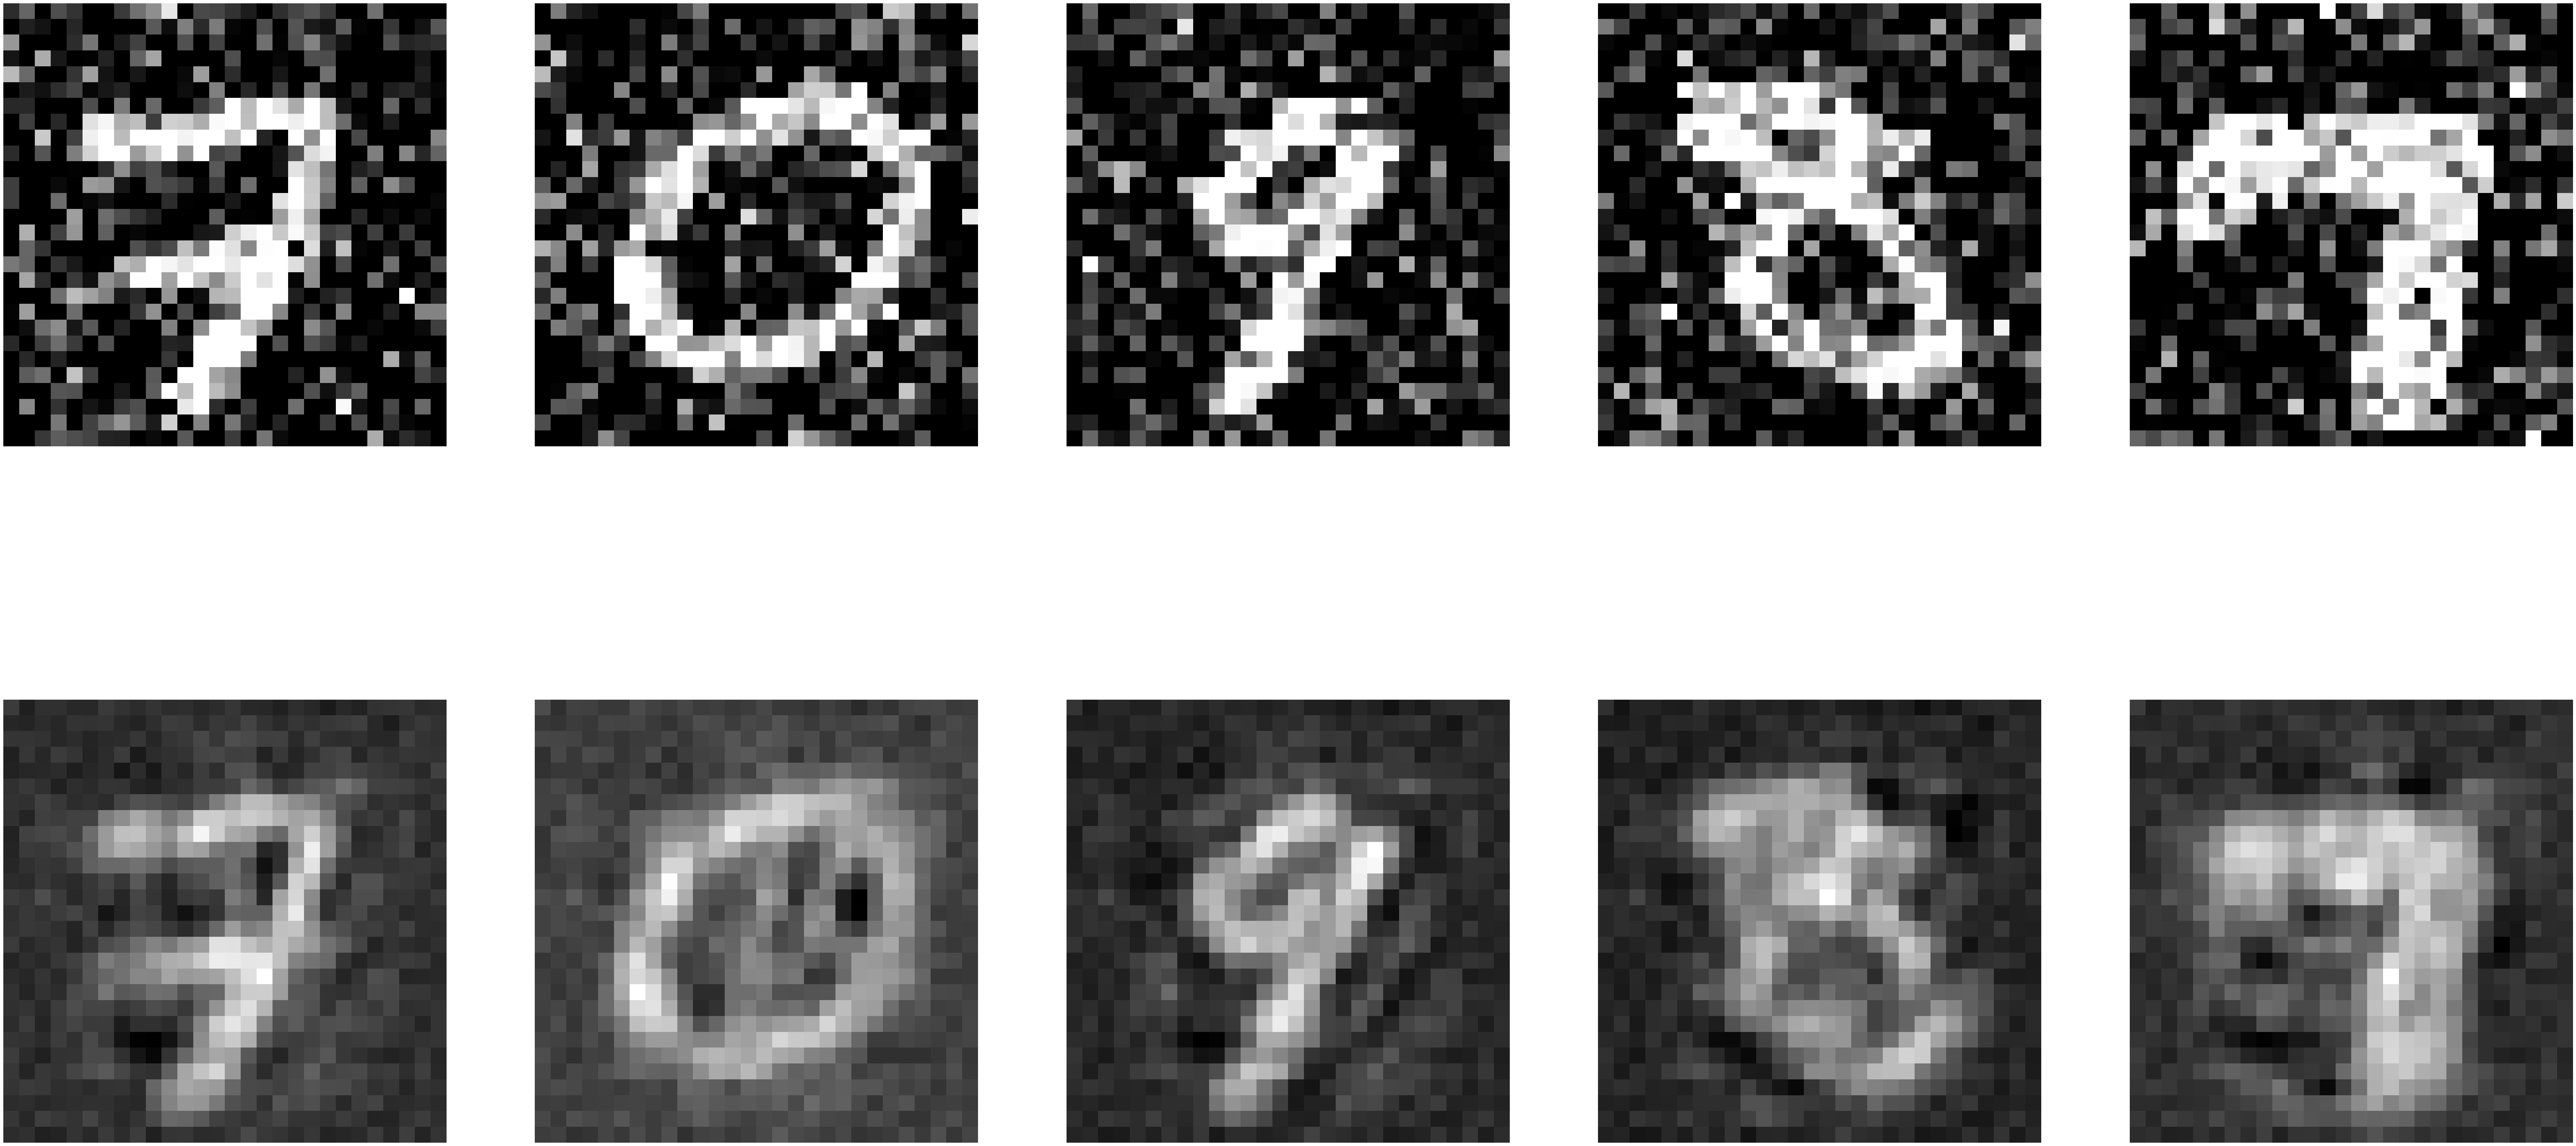

In [411]:
figure = plt.figure(figsize=(100, 50))
cols, rows = 5, 2
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i + 1)
    plt.axis("off")
    if i < cols:
        plt.imshow(data_train[i][0][0], cmap="gray")
    else:
        plt.imshow(denoised_train[i % 5][0], cmap="gray")
plt.show()

### 4.6.3, 4.6.4, 4.6.5

In [412]:
denoised_train = TensorDataset(denoised_train, lbls_train)
denoised_val = TensorDataset(denoised_val, lbls_val)
denoised_test = TensorDataset(denoised_test, lbls_test)

inputs = [denoised_train, denoised_val, denoised_test]

best_params = {
        'stride1': 1,
        'stride2': 2,
        'stride3': 1,
        'stride4': 2,
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
        'epochs': 1,
        'batch_size': 64,
}
_, y_pred, y_true = train_test(test=True, params=best_params, data=inputs)

print(f"\nClassification report for classifier for the best parameters\n")
print(classification_report(y_true, y_pred, labels=range(10), zero_division=1.0))

# 5 Some Other Variants

## 5.1  Multi-digit Recognition on Multi-MNIST Dataset 

In [39]:
group_name = 'Multi MNIST'

In [40]:
import os
from PIL import Image

transform = transforms.ToTensor()

def load(path):
    data = []

    lbls = os.listdir(path)
    for lbl in lbls:
        if lbl[0] == lbl[1]:
            continue
        lbl_folder = os.path.join(path, lbl)
        img_files = os.listdir(lbl_folder)
        for img_file in img_files:
            img_path = os.path.join(lbl_folder, img_file)
            img = Image.open(img_path)
            data.append([transform(img), lbl])
            img.close()
    return data, len(data)

In [41]:
path = './double_mnist_seed_123_image_size_64_64/'

data_train, train_size = load(path + 'train')
data_val, val_size = load(path + 'val')
data_test, test_size = load(path + 'test')

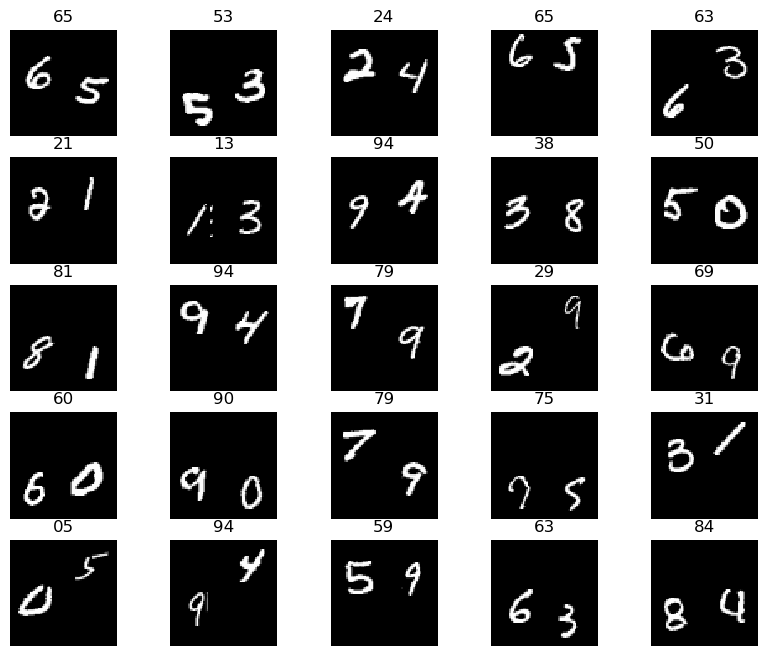

In [42]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(cols * rows):
    img, lbl = data_train[np.random.randint(1, len(data_train))]
    figure.add_subplot(rows, cols, i + 1)
    plt.title(lbl)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [43]:
data = data_train + data_val + data_test

for i in range(len(data)):
    encoder = np.zeros(20)
    
    lbl = data[i][1]
    if isinstance(lbl, str):
        a, b = int(lbl[0]), int(lbl[1])
        encoder[a] = 1
        encoder[b + 10] = 1
    else:
        encoder[lbl] = 1
    data[i][1] = encoder

ratio = (0.7, 0.15, 0.15)
batch_size = 64

total_size = len(data)
train_size = int(ratio[0] * total_size)
val_size = int(ratio[1] * total_size)
test_size = total_size - train_size - val_size

gen=torch.Generator().manual_seed(0)
data_train, data_val, data_test = random_split(data, [train_size, val_size, test_size], generator=gen)

inputs = (data_train, data_val, data_test)

# loaders = {
#         'train': DataLoader(inputs[0], batch_size=batch_size, shuffle=True),
#         'val': DataLoader(inputs[1], batch_size=batch_size),
#         'test': DataLoader(inputs[2], batch_size=batch_size),
#     }

### 5.1.1 MLP on Multi-MNIST

In [19]:
class MLP(nn.Module):
    def __init__(self, layers=[1000, ]):
        super(MLP, self).__init__()
        self.layers = self.__initialise_layers__(layers)
        self.softmax = nn.Softmax(1)
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = optim.Adam(self.parameters(), lr=1e-3)
        
    def __initialise_layers__(self, layers):
        layers = [64 * 64, ] + layers + [20, ]
        lyrs = nn.ModuleList()
        for i in range(0, len(layers) - 1):
            layer = nn.Sequential(
                nn.Linear(layers[i], layers[i + 1]),
                nn.ReLU(),
            )
            lyrs.append(layer)
        
        return lyrs
    
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        for lyr in self.layers:
            x = lyr(x)
#         x = self.softmax(x)
        return x

In [140]:
train_test(data=inputs)

Epoch [1/1] loss:  6.02 - accuracy:  9.97% - val_loss:  5.99 - val_accuracy:  10.07%


0.1007037037037037

In [20]:
def train_test(test=False, params=None, data=None):
    # For logging during tuning (sweeps)
    final_accuracy = 0.0
    
    batch_size = 64
    epochs = 1
    if params is None:
        model = MLP()
    else:
        model = MLP(**params)
        
    criterion = model.criterion
    optimizer = model.optimiser
    
    loaders = {
        'train': DataLoader(data[0], batch_size=batch_size, shuffle=True),
        'val': DataLoader(data[1], batch_size=batch_size),
        'test': DataLoader(data[2], batch_size=batch_size),
    }
    
    # This also copied from another cell which was above test_model function and made minor changes
    for ep in range(epochs):
        model.train()

        ep_loss = 0.0
        ep_corr = 0
        ep_total = 0
        for _, (inputs, labels) in enumerate(loaders['train']):
            outputs = model(inputs)
            
            lbls1, lbls2 = np.hsplit(labels, 2)
            outs1, outs2 = np.hsplit(outputs.data, 2)
            
            lbls1, lbls2 = np.argmax(lbls1, axis=1), np.argmax(lbls2, axis=1)
            outs1, outs2 = np.argmax(outs1, axis=1), np.argmax(outs2, axis=1)
           
            ep_total += 2 * labels.size(0) 
            ep_corr += (outs1 == lbls1).sum().item() + (outs2 == lbls2).sum().item()
            
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ep_loss += loss.item()

        # Function test_model copied here
        model.eval()

        ep_val_loss = 0.0  
        ep_val_corr = 0  
        ep_val_total = 0  

        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                
                lbls1, lbls2 = np.hsplit(labels, 2)
                outs1, outs2 = np.hsplit(outputs.data, 2)
            
                lbls1, lbls2 = np.argmax(lbls1, axis=1), np.argmax(lbls2, axis=1)
                outs1, outs2 = np.argmax(outs1, axis=1), np.argmax(outs2, axis=1)
                
                ep_val_total += 2 * labels.size(0) 
                ep_val_corr += (outs1 == lbls1).sum().item() + (outs2 == lbls2).sum().item()

                loss = criterion(outputs, labels)
                ep_val_loss += loss.item()

        loss, val_loss = ep_loss / len(loaders['train']), ep_val_loss / len(loaders['val'])
        accuracy, val_accuracy = ep_corr / ep_total, ep_val_corr / ep_val_total
        data_log = {
            'ep_loss': loss,
            'ep_accuracy': accuracy,
            'ep_val_loss': val_loss,
            'ep_val_accuracy': val_accuracy,
        }
#         wandb.log(data_log)
        print(f"Epoch [{ep + 1}/{epochs}] loss: {loss: .2f} - accuracy: {accuracy: .2%} - val_loss: {val_loss: .2f} - val_accuracy: {val_accuracy: .2%}")
        if ep + 1 == epochs:
            final_accuracy = val_accuracy
    
    if test:
        model.eval()
        
        total_loss = 0.0  
        corr = 0  
        total = 0
        
        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['test']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                
                lbls1, lbls2 = np.hsplit(labels, 2)
                outs1, outs2 = np.hsplit(outputs.data, 2)
            
                lbls1, lbls2 = np.argmax(lbls1, axis=1), np.argmax(lbls2, axis=1)
                outs1, outs2 = np.argmax(outs1, axis=1), np.argmax(outs2, axis=1)
    
                total += 2 * labels.size(0) 
                corr += (outs1 == lbls1).sum().item() + (outs2 == lbls2).sum().item()

                loss = criterion(outputs, labels)
                total_loss += loss.item()

        loss = total_loss / len(loaders['test'])
        accuracy = corr / total
        print(f"\ntest_loss: {loss: .2f} - test_accuracy: {accuracy: .2%}")
    
    return final_accuracy

In [24]:
def train():
    config_defaults = {
        'layers': [1000, ],
    }
    
    wandb.init(
    group=group_name,
    config=config_defaults)
    
    config = wandb.config
    accuracy = train_test(data=inputs, params=config)    
    
    wandb.log({'accuracy': accuracy})

In [22]:
sweep_config = {
    'method': 'grid',
    'name': 'MLP Multi MNIST Tuning',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'layers': {
            'values': [[1000, ], [2000, 1000, ], ]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)
wandb.agent(sweep_id, function=train)

Create sweep with ID: ypagvjng
Sweep URL: https://wandb.ai/vedanivas/uncategorized/sweeps/ypagvjng


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: fy0gz99x with config:
wandb: 	layers: [1000]


Epoch [1/1] loss:  4.79 - accuracy:  46.18% - val_loss:  4.14 - val_accuracy:  60.47%


accuracy,▁
accuracy,0.60474


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: 7fuslrwh with config:
wandb: 	layers: [2000, 1000]


Epoch [1/1] loss:  5.73 - accuracy:  19.45% - val_loss:  5.69 - val_accuracy:  19.88%


accuracy,▁
accuracy,0.19881


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [23]:
best_params = {
    'layers': [1000, ],
}

accuracy = train_test(test=True, data=inputs, params=best_params)

print(f"Accuracy: {accuracy}")

Epoch [1/1] loss:  5.21 - accuracy:  34.54% - val_loss:  4.87 - val_accuracy:  41.04%

test_loss:  4.89 - test_accuracy:  40.30%
Accuracy: 0.41044444444444445


### 5.1.2  CNN on Multi-MNIST

In [44]:
# Change default out_shape to 16 in argument of init

class MultiCNN(nn.Module):
    # Not using batch_size and epochs inside the CNN class, but have to put it as argument in __init__ due to some error
    def __init__(self, size1=5, size2=2, size3=5, size4=2, stride1=1, stride2=2, stride3=1, stride4=2, dropout_rate=0.5, alpha=1e-2, out_shape=16, epochs=0, batch_size=0):
        super(MultiCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=size1, stride=stride1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=size2, stride=stride2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=size3, stride=stride3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=size4, stride=stride4))
        self.drop_out = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(out_shape * out_shape * 64, 1000)
        self.fc2 = nn.Linear(1000, 20)
        self.softmax = nn.Softmax(1)
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = optim.Adam(self.parameters(), lr=alpha)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [76]:
train_test(data=inputs)

Epoch [1/1] loss:  5.47 - accuracy:  26.06% - val_loss:  4.92 - val_accuracy:  35.14%


0.3514074074074074

In [49]:
def train_test(test=False, params=None, data=None):
    # For logging during tuning (sweeps)
    final_accuracy = 0.0
    
    batch_size = 64
    epochs = 1
    if params is None:
        model = MultiCNN()
    else:
        # Taking padding as 2 always
        out_shape = int((data[0][0][0].size(1) - params['size1'] + 4) / params['stride1']) + 1
        out_shape = int((out_shape - params['size2']) / params['stride2']) + 1 
        out_shape = int((out_shape - params['size3'] + 4) / params['stride3']) + 1 
        out_shape = int((out_shape - params['size4']) / params['stride4']) + 1 
        params['out_shape'] = out_shape
        model = MultiCNN(**params)
    criterion = model.criterion
    optimizer = model.optimiser
    
    loaders = {
        'train': DataLoader(data[0], batch_size=batch_size, shuffle=True),
        'val': DataLoader(data[1], batch_size=batch_size),
        'test': DataLoader(data[2], batch_size=batch_size),
    }
    
    # This also copied from another cell which was above test_model function and made minor changes
    for ep in range(epochs):
        model.train()

        ep_loss = 0.0
        ep_corr = 0
        ep_total = 0
        for _, (inputs, labels) in enumerate(loaders['train']):
            outputs = model(inputs)
            
            lbls1, lbls2 = np.hsplit(labels, 2)
            outs1, outs2 = np.hsplit(outputs.data, 2)
            
            lbls1, lbls2 = np.argmax(lbls1, axis=1), np.argmax(lbls2, axis=1)
            outs1, outs2 = np.argmax(outs1, axis=1), np.argmax(outs2, axis=1)
           
            ep_total += 2 * labels.size(0) 
            ep_corr += (outs1 == lbls1).sum().item() + (outs2 == lbls2).sum().item()
            
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ep_loss += loss.item()

        # Function test_model copied here
        model.eval()

        ep_val_loss = 0.0  
        ep_val_corr = 0  
        ep_val_total = 0  

        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                
                lbls1, lbls2 = np.hsplit(labels, 2)
                outs1, outs2 = np.hsplit(outputs.data, 2)
            
                lbls1, lbls2 = np.argmax(lbls1, axis=1), np.argmax(lbls2, axis=1)
                outs1, outs2 = np.argmax(outs1, axis=1), np.argmax(outs2, axis=1)
                
                ep_val_total += 2 * labels.size(0) 
                ep_val_corr += (outs1 == lbls1).sum().item() + (outs2 == lbls2).sum().item()

                loss = criterion(outputs, labels)
                ep_val_loss += loss.item()

        loss, val_loss = ep_loss / len(loaders['train']), ep_val_loss / len(loaders['val'])
        accuracy, val_accuracy = ep_corr / ep_total, ep_val_corr / ep_val_total
        data_log = {
            'ep_loss': loss,
            'ep_accuracy': accuracy,
            'ep_val_loss': val_loss,
            'ep_val_accuracy': val_accuracy,
        }
        wandb.log(data_log)
        print(f"Epoch [{ep + 1}/{epochs}] loss: {loss: .2f} - accuracy: {accuracy: .2%} - val_loss: {val_loss: .2f} - val_accuracy: {val_accuracy: .2%}")
        if ep + 1 == epochs:
            final_accuracy = val_accuracy
    
    if test:
        model.eval()
        
        total_loss = 0.0  
        corr = 0  
        total = 0
        
        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['test']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                
                lbls1, lbls2 = np.hsplit(labels, 2)
                outs1, outs2 = np.hsplit(outputs.data, 2)
            
                lbls1, lbls2 = np.argmax(lbls1, axis=1), np.argmax(lbls2, axis=1)
                outs1, outs2 = np.argmax(outs1, axis=1), np.argmax(outs2, axis=1)
    
                total += 2 * labels.size(0) 
                corr += (outs1 == lbls1).sum().item() + (outs2 == lbls2).sum().item()

                loss = criterion(outputs, labels)
                total_loss += loss.item()

        loss = total_loss / len(loaders['test'])
        accuracy = corr / total
        print(f"\ntest_loss: {loss: .2f} - test_accuracy: {accuracy: .2%}")
    
    return final_accuracy

In [50]:
def train():
    config_defaults = {
        'stride1': 1,
        'stride2': 2,
        'stride3': 1,
        'stride4': 2,
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
    }
    
    wandb.init(
    group=group_name,
    entity=entity,
    config=config_defaults)
    
    config = wandb.config
    accuracy = train_test(data=inputs, params=config)    
    
    wandb.log({'accuracy': accuracy})

In [51]:
sweep_config = {
    'method': 'grid',
    'name': 'CNN Multi MNIST Tuning',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'stride1': {
            'values': [1, ]
        },
        'stride2': {
            'values': [2, ]
        },
        'stride3': {
            'values': [1, ]
        },
        'stride4': {
            'values': [2, ]
        },
        'size1': {
            'values': [5, ]
        },
        'size2': {
            'values': [2, ]
        },
        'size3': {
            'values': [5, ]
        },
        'size4': {
            'values': [2, ]
        },
        'alpha': {
            'values': [1e-2, ]
        },
        'dropout_rate': {
            'values': [0.5, 0]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)
wandb.agent(sweep_id, function=train)

Create sweep with ID: x0wz07zn
Sweep URL: https://wandb.ai/vedanivas/SMAI-A3/sweeps/x0wz07zn


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: 5hhp2mfr with config:
wandb: 	alpha: 0.01
wandb: 	dropout_rate: 0.5
wandb: 	size1: 5
wandb: 	size2: 2
wandb: 	size3: 5
wandb: 	size4: 2
wandb: 	stride1: 1
wandb: 	stride2: 2
wandb: 	stride3: 1
wandb: 	stride4: 2
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/1] loss:  6.06 - accuracy:  9.89% - val_loss:  6.05 - val_accuracy:  10.26%


accuracy,▁
ep_accuracy,▁
ep_loss,▁
ep_val_accuracy,▁
ep_val_loss,▁
accuracy,0.10259
ep_accuracy,0.09889
ep_loss,6.05684
ep_val_accuracy,0.10259
ep_val_loss,6.05418


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: 1yv6ahcp with config:
wandb: 	alpha: 0.01
wandb: 	dropout_rate: 0
wandb: 	size1: 5
wandb: 	size2: 2
wandb: 	size3: 5
wandb: 	size4: 2
wandb: 	stride1: 1
wandb: 	stride2: 2
wandb: 	stride3: 1
wandb: 	stride4: 2
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/1] loss:  6.05 - accuracy:  10.12% - val_loss:  6.06 - val_accuracy:  9.76%


accuracy,▁
ep_accuracy,▁
ep_loss,▁
ep_val_accuracy,▁
ep_val_loss,▁
accuracy,0.09763
ep_accuracy,0.10115
ep_loss,6.05492
ep_val_accuracy,0.09763
ep_val_loss,6.05941


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
best_params = {
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
}

wandb.init(group=group_name)
accuracy = train_test(test=True, params=best_params, data=inputs)
wandb.finish()
print(f"Accuracy: {accuracy}")

## 5.2 Permuted MNIST

In [52]:
group_name = 'Permuted MNIST'

In [53]:
data = np.load("permuted_mnist.npz")

In [54]:
transform = transforms.Compose([transforms.ToTensor()])

data_x_train, data_y_train = transform(data['train_images']), torch.tensor(data['train_labels'])
data_x_test, data_y_test = transform(data['test_images']), torch.tensor(data['test_labels'])

In [55]:
data_x_train = data_x_train.view(1, 60000, 1, 28, 28)
data_x_test = data_x_test.view(1, 10000, 1, 28, 28)

data_x, data_y = torch.cat((data_x_train, data_x_test), dim=1), torch.cat((data_y_train, data_y_test))

data = TensorDataset(data_x[0], data_y)

ratio = (0.7, 0.15, 0.15)
batch_size = 64

total_size = len(data)
train_size = int(ratio[0] * total_size)
val_size = int(ratio[1] * total_size)
test_size = total_size - train_size - val_size

gen=torch.Generator().manual_seed(0)
data_train, data_val, data_test = random_split(data, [train_size, val_size, test_size], generator=gen)

inputs = (data_train, data_val, data_test)

### 5.2.1 MLP on Permuted-MNIST

In [30]:
class MLPPermuted(nn.Module):
    def __init__(self, layers=[1000, ]):
        super(MLPPermuted, self).__init__()
        self.layers = self.__initialise_layers__(layers)
        self.softmax = nn.Softmax(1)
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = optim.Adam(self.parameters(), lr=1e-3)
        
    def __initialise_layers__(self, layers):
        layers = [28 * 28, ] + layers + [10, ]
        lyrs = nn.ModuleList()
        for i in range(0, len(layers) - 1):
            layer = nn.Sequential(
                nn.Linear(layers[i], layers[i + 1]),
                nn.ReLU(),
            )
            lyrs.append(layer)
        
        return lyrs
    
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        for lyr in self.layers:
            x = lyr(x)
#         x = self.softmax(x)
        return x

In [31]:
def train_test(test=False, visualise=False, params=None, data=None):    
    # For logging during tuning (sweeps)
    final_accuracy = 0.0
    
    batch_size = 64
    epochs = 10
    if params is None:
        model = MLPPermuted()
    else:
        model = MLPPermuted(**params)
    criterion = model.criterion
    optimizer = model.optimiser
    
    loaders = {
        'train': DataLoader(data[0], batch_size=batch_size, shuffle=True),
        'val': DataLoader(data[1], batch_size=batch_size),
        'test': DataLoader(data[2], batch_size=batch_size),
    }
    
    # This also copied from another cell which was above test_model function and made minor changes
    for ep in range(epochs):
        model.train()

        ep_loss = 0.0
        ep_corr = 0
        ep_total = 0
        for _, (inputs, labels) in enumerate(loaders['train']):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            ep_total += labels.size(0) 
            ep_corr += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ep_loss += loss.item()

        # Function test_model copied here
        model.eval()

        ep_val_loss = 0.0  
        ep_val_corr = 0  
        ep_val_total = 0  

        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                _, predicted = torch.max(outputs.data, 1)

                ep_val_total += labels.size(0) 
                ep_val_corr += (predicted == labels).sum().item() 

                loss = criterion(outputs, labels)
                ep_val_loss += loss.item()

        loss, val_loss = ep_loss / len(loaders['train']), ep_val_loss / len(loaders['val'])
        accuracy, val_accuracy = ep_corr / ep_total, ep_val_corr / ep_val_total
        data_log = {
            'ep_loss': loss,
            'ep_accuracy': accuracy,
            'ep_val_loss': val_loss,
            'ep_val_accuracy': val_accuracy,
        }
        wandb.log(data_log)
        print(f"Epoch [{ep + 1}/{epochs}] loss: {loss: .2f} - accuracy: {accuracy: .2%} - val_loss: {val_loss: .2f} - val_accuracy: {val_accuracy: .2%}")
        if ep + 1 == epochs:
            final_accuracy = val_accuracy
    
    if test:
        model.eval()
        
        total_loss = 0.0  
        corr = 0  
        total = 0 
        
        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['test']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0) 
                corr += (predicted == labels).sum().item() 

                loss = criterion(outputs, labels)
                total_loss += loss.item()

        loss = total_loss / len(loaders['test'])
        accuracy = corr / total
        print(f"\ntest_loss: {loss: .2f} - test_accuracy: {accuracy: .2%}")
    
    return final_accuracy

In [168]:
train_test(data=inputs)

Epoch [1/10] loss:  2.69 - accuracy:  10.40% - val_loss:  2.68 - val_accuracy:  11.48%
Epoch [2/10] loss:  2.67 - accuracy:  12.06% - val_loss:  2.69 - val_accuracy:  9.82%
Epoch [3/10] loss:  2.62 - accuracy:  15.77% - val_loss:  2.71 - val_accuracy:  10.48%
Epoch [4/10] loss:  2.51 - accuracy:  22.27% - val_loss:  2.80 - val_accuracy:  10.05%
Epoch [5/10] loss:  2.31 - accuracy:  31.80% - val_loss:  2.90 - val_accuracy:  9.67%
Epoch [6/10] loss:  2.02 - accuracy:  43.90% - val_loss:  3.03 - val_accuracy:  10.08%
Epoch [7/10] loss:  1.68 - accuracy:  57.39% - val_loss:  3.20 - val_accuracy:  9.64%
Epoch [8/10] loss:  1.33 - accuracy:  68.84% - val_loss:  3.31 - val_accuracy:  10.15%
Epoch [9/10] loss:  1.05 - accuracy:  75.89% - val_loss:  3.39 - val_accuracy:  10.19%
Epoch [10/10] loss:  0.86 - accuracy:  78.76% - val_loss:  3.51 - val_accuracy:  9.90%


0.09895238095238096

In [32]:
def train():
    config_defaults = {
        'layers': [1000, ],
    }
    
    wandb.init(
    group=group_name,
    config=config_defaults)
    
    config = wandb.config
    accuracy = train_test(data=inputs, params=config)    
    
    wandb.log({'accuracy': accuracy})

In [33]:
sweep_config = {
    'method': 'grid',
    'name': 'MLP Permuted MNIST Tuning',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'layers': {
            'values': [[1000, ], [2000, 1000, ], ]
        },
    }
}

sweep_id = wandb.sweep(sweep_config)
wandb.agent(sweep_id, function=train)

Create sweep with ID: uzcksp4o
Sweep URL: https://wandb.ai/vedanivas/uncategorized/sweeps/uzcksp4o


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: 2coj9aux with config:
wandb: 	layers: [1000]


Epoch [1/10] loss:  2.30 - accuracy:  9.94% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [2/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [3/10] loss:  2.30 - accuracy:  9.91% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [4/10] loss:  2.30 - accuracy:  9.91% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [5/10] loss:  2.30 - accuracy:  9.91% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [6/10] loss:  2.30 - accuracy:  9.92% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [7/10] loss:  2.30 - accuracy:  9.92% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [8/10] loss:  2.30 - accuracy:  9.92% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [9/10] loss:  2.30 - accuracy:  9.92% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [10/10] loss:  2.30 - accuracy:  9.92% - val_loss:  2.30 - val_accuracy:  9.94%


accuracy,▁
ep_accuracy,█▁▃▃▃▄▄▅▅▅
ep_loss,█▇▇▆▄▅▃▂▁▁
ep_val_accuracy,▁▁▁▁▁▁▁▁▁▁
ep_val_loss,▁▁▁▁▁▁▁█▁▁
accuracy,0.09943
ep_accuracy,0.09922
ep_loss,2.30146
ep_val_accuracy,0.09943
ep_val_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: 7bttjxr0 with config:
wandb: 	layers: [2000, 1000]


Epoch [1/10] loss:  2.30 - accuracy:  9.94% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [2/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [3/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [4/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [5/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [6/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [7/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [8/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [9/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%
Epoch [10/10] loss:  2.30 - accuracy:  9.90% - val_loss:  2.30 - val_accuracy:  9.94%


accuracy,▁
ep_accuracy,█▁▁▁▁▁▁▁▁▁
ep_loss,█▁▁▁▁▁▁▁▁▁
ep_val_accuracy,▁▁▁▁▁▁▁▁▁▁
ep_val_loss,▁▁▁▁▁▁▁▁▁▁
accuracy,0.09943
ep_accuracy,0.09896
ep_loss,2.30259
ep_val_accuracy,0.09943
ep_val_loss,2.30259


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [36]:
best_params = {
    'layers': [1000, ],
}

wandb.init(group=group_name)
accuracy = train_test(test=True, data=inputs, params=best_params)
wandb.finish()

print(f"Accuracy: {accuracy}")

Error: You must call wandb.init() before wandb.log()

### 5.2.2 CNN on Permuted-MNIST

In [56]:
class MultiCNNPermuted(nn.Module):
    # Not using batch_size and epochs inside the CNN class, but have to put it as argument in __init__ due to some error
    def __init__(self, size1=5, size2=2, size3=5, size4=2, stride1=1, stride2=2, stride3=1, stride4=2, dropout_rate=0.5, alpha=1e-2, out_shape=7, epochs=0, batch_size=0):
        super(MultiCNNPermuted, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=size1, stride=stride1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=size2, stride=stride2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=size3, stride=stride3, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=size4, stride=stride4))
        self.drop_out = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(out_shape * out_shape * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        self.softmax = nn.Softmax(1)
        self.criterion = nn.CrossEntropyLoss()
        self.optimiser = optim.Adam(self.parameters(), lr=alpha)
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [59]:
def train_test(test=False, params=None, data=None):    
    # For logging during tuning (sweeps)
    final_accuracy = 0.0
    
    batch_size = 64
    epochs = 1
    if params is None:
        model = MultiCNNPermuted()
    else:
        # Taking padding as 2 always
        out_shape = int((data[0][0][0].size(1) - params['size1'] + 4) / params['stride1']) + 1
        out_shape = int((out_shape - params['size2']) / params['stride2']) + 1 
        out_shape = int((out_shape - params['size3'] + 4) / params['stride3']) + 1 
        out_shape = int((out_shape - params['size4']) / params['stride4']) + 1
        params['out_shape'] = out_shape
        model = MultiCNNPermuted(**params)
    criterion = model.criterion
    optimizer = model.optimiser
    
    loaders = {
        'train': DataLoader(data[0], batch_size=batch_size, shuffle=True),
        'val': DataLoader(data[1], batch_size=batch_size),
        'test': DataLoader(data[2], batch_size=batch_size),
    }
    
    # This also copied from another cell which was above test_model function and made minor changes
    for ep in range(epochs):
        model.train()

        ep_loss = 0.0
        ep_corr = 0
        ep_total = 0
        for _, (inputs, labels) in enumerate(loaders['train']):
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            ep_total += labels.size(0) 
            ep_corr += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ep_loss += loss.item()

        # Function test_model copied here
        model.eval()

        ep_val_loss = 0.0  
        ep_val_corr = 0  
        ep_val_total = 0  

        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['val']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                _, predicted = torch.max(outputs.data, 1)

                ep_val_total += labels.size(0) 
                ep_val_corr += (predicted == labels).sum().item() 

                loss = criterion(outputs, labels)
                ep_val_loss += loss.item()

        loss, val_loss = ep_loss / len(loaders['train']), ep_val_loss / len(loaders['val'])
        accuracy, val_accuracy = ep_corr / ep_total, ep_val_corr / ep_val_total
        data_log = {
            'ep_loss': loss,
            'ep_accuracy': accuracy,
            'ep_val_loss': val_loss,
            'ep_val_accuracy': val_accuracy,
        }
        wandb.log(data_log)
        print(f"Epoch [{ep + 1}/{epochs}] loss: {loss: .2f} - accuracy: {accuracy: .2%} - val_loss: {val_loss: .2f} - val_accuracy: {val_accuracy: .2%}")
        if ep + 1 == epochs:
            final_accuracy = val_accuracy
    
    if test:
        model.eval()
        
        total_loss = 0.0  
        corr = 0  
        total = 0 
        
        with torch.no_grad():  
            for _, (inputs, labels) in enumerate(loaders['test']):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0) 
                corr += (predicted == labels).sum().item() 

                loss = criterion(outputs, labels)
                total_loss += loss.item()

        loss = total_loss / len(loaders['test'])
        accuracy = corr / total
        print(f"\ntest_loss: {loss: .2f} - test_accuracy: {accuracy: .2%}")
    
    return final_accuracy

In [173]:
train_test(data=inputs)

Epoch [1/10] loss:  2.36 - accuracy:  10.45% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [2/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [3/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [4/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [5/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [6/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [7/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [8/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [9/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%
Epoch [10/10] loss:  2.36 - accuracy:  10.44% - val_loss:  2.36 - val_accuracy:  10.56%


0.10561904761904761

In [60]:
def train():
    config_defaults = {
        'stride1': 1,
        'stride2': 2,
        'stride3': 1,
        'stride4': 2,
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
    }
    
    wandb.init(
    group=group_name,
    entity=entity,
    config=config_defaults)
    
    config = wandb.config
    accuracy = train_test(data=inputs, params=config)    
    
    wandb.log({'accuracy': accuracy})

In [61]:
sweep_config = {
    'method': 'grid',
    'name': 'CNN Permuted MNIST Tuning',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'stride1': {
            'values': [1, ]
        },
        'stride2': {
            'values': [2, ]
        },
        'stride3': {
            'values': [1, ]
        },
        'stride4': {
            'values': [2, ]
        },
        'size1': {
            'values': [5, ]
        },
        'size2': {
            'values': [2, ]
        },
        'size3': {
            'values': [5, ]
        },
        'size4': {
            'values': [2, ]
        },
        'alpha': {
            'values': [1e-2, ]
        },
        'dropout_rate': {
            'values': [0.5, 0]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)
wandb.agent(sweep_id, function=train)

Create sweep with ID: 0osmzbg6
Sweep URL: https://wandb.ai/vedanivas/SMAI-A3/sweeps/0osmzbg6


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: oo7qbzk9 with config:
wandb: 	alpha: 0.01
wandb: 	dropout_rate: 0.5
wandb: 	size1: 5
wandb: 	size2: 2
wandb: 	size3: 5
wandb: 	size4: 2
wandb: 	stride1: 1
wandb: 	stride2: 2
wandb: 	stride3: 1
wandb: 	stride4: 2
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5] loss:  2.35 - accuracy:  11.28% - val_loss:  2.34 - val_accuracy:  11.77%
Epoch [2/5] loss:  2.35 - accuracy:  11.29% - val_loss:  2.34 - val_accuracy:  11.77%
Epoch [3/5] loss:  2.35 - accuracy:  11.29% - val_loss:  2.34 - val_accuracy:  11.77%
Epoch [4/5] loss:  2.35 - accuracy:  11.29% - val_loss:  2.34 - val_accuracy:  11.77%
Epoch [5/5] loss:  2.35 - accuracy:  11.29% - val_loss:  2.34 - val_accuracy:  11.77%


accuracy,▁
ep_accuracy,▁████
ep_loss,▁▃▁█▆
ep_val_accuracy,▁▁▁▁▁
ep_val_loss,▁▁▁▁▁
accuracy,0.11771
ep_accuracy,0.11286
ep_loss,2.3483
ep_val_accuracy,0.11771
ep_val_loss,2.34268


/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.0) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Agent Starting Run: e9hvdtmp with config:
wandb: 	alpha: 0.01
wandb: 	dropout_rate: 0
wandb: 	size1: 5
wandb: 	size2: 2
wandb: 	size3: 5
wandb: 	size4: 2
wandb: 	stride1: 1
wandb: 	stride2: 2
wandb: 	stride3: 1
wandb: 	stride4: 2
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch [1/5] loss:  2.36 - accuracy:  10.23% - val_loss:  2.36 - val_accuracy:  9.93%
Epoch [2/5] loss:  2.36 - accuracy:  10.24% - val_loss:  2.36 - val_accuracy:  9.93%
Epoch [3/5] loss:  2.36 - accuracy:  10.24% - val_loss:  2.36 - val_accuracy:  9.93%
Epoch [4/5] loss:  2.36 - accuracy:  10.24% - val_loss:  2.36 - val_accuracy:  9.93%
Epoch [5/5] loss:  2.36 - accuracy:  10.24% - val_loss:  2.36 - val_accuracy:  9.93%


accuracy,▁
ep_accuracy,▁████
ep_loss,▁▆▁██
ep_val_accuracy,▁▁▁▁▁
ep_val_loss,▁▁▁▁▁
accuracy,0.09933
ep_accuracy,0.10241
ep_loss,2.35874
ep_val_accuracy,0.09933
ep_val_loss,2.36096


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [ ]:
best_params = {
        'size1': 5,
        'size2': 2,
        'size3': 5,
        'size4': 2,
        'dropout_rate': 0.5,
        'alpha': 1e-3,
}

wandb.init(group=group_name)
accuracy = train_test(test=True, params=best_params, data=inputs)
wandb.finish()
print(f"Accuracy: {accuracy}")

## Report for this part
[Link](https://api.wandb.ai/links/vedanivas/ytos1wd7)